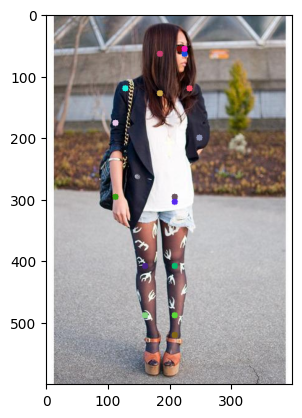

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import graph, color

BODY_PARTS = {
    "Nose": 0,
    "Neck": 1,
    "RShoulder": 2,
    "RElbow": 3,
    "RWrist": 4,
    "LShoulder": 5,
    "LElbow": 6,
    "LWrist": 7,
    "RHip": 8,
    "RKnee": 9,
    "RAnkle": 10,
    "LHip": 11,
    "LKnee": 12,
    "LAnkle": 13,
    "REye": 14,
    "LEye": 15,
    "REar": 16,
    "LEar": 17,
}

net = cv2.dnn.readNetFromTensorflow("graph_opt.pb")

img_path = "data/images/0001.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height = image.shape[0]
width = image.shape[1]

net.setInput(
    cv2.dnn.blobFromImage(
        image, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB=True, crop=False
    )
)
out = net.forward()
out = out[:, :19, :, :]

out_image = image.copy()

for i in range(len(BODY_PARTS)):
    heatMap = out[0, i, :, :]
    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (width * point[0]) / out.shape[3]
    y = (height * point[1]) / out.shape[2]
    color = np.random.randint(0, 256, 3).tolist()
    cv2.circle(out_image, (int(x), int(y)), 5, color, cv2.FILLED)

plt.imshow(out_image)

In [3]:
# Now I will load my model remove the background and then segment the image with superpixels
import torch

best_model = torch.load("saved_models/DeepLabv3_2.pt")
best_model.eval()

DeepLabv3(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, ker

Felzenszwalb number of segments: 78


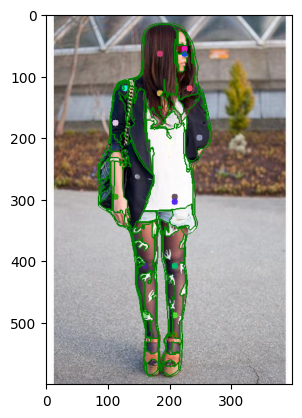

In [7]:
from utils import to_tensor_lab, remove_small_artifacts
import cv2

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_tensor = to_tensor_lab(image)
pred_mask = best_model(image_tensor.cuda())
pred_mask = pred_mask.argmax(dim=1).cpu().numpy()[0]
pred_mask = remove_small_artifacts(pred_mask, 300)
image[pred_mask == 0] = [128, 128, 128]
segments_fz = felzenszwalb(image, scale=150, min_size=100, channel_axis=2)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")

plt.imshow(mark_boundaries(out_image, segments_fz, color=(0, 0.5, 0)))
plt.show()